Project: Developing ML tool to detect alcoholism using EEG data
Dataset downloaded from https://www.kaggle.com/nnair25/Alcoholics#

This data arises from a large study to examine EEG correlates of genetic predisposition to alcoholism. It contains measurements from 64 electrodes placed on the subject's scalps, which were sampled at 256 Hz (3.9-msec epoch) for 1 second.

There were two groups of subjects: alcoholic and control. Each subject was exposed to either a single stimulus (S1) or to two stimuli (S1 and S2) which were pictures of objects chosen from the 1980 Snodgrass and Vanderwart picture set. When two stimuli were shown, they were presented in either a matched condition where S1 was identical to S2 or in a non-matched condition where S1 differed from S2.

There were 122 subjects and each subject completed 120 trials where different stimuli were shown. However in this project, only data from 16 subjects will be analyzed here.

The electrode positions were located at standard sites (Standard Electrode Position Nomenclature, American Electroencephalographic Association 1990). Zhang et al. (1995) describes in detail the data collection process. (Info taken from https://archive.ics.uci.edu/ml/datasets/eeg+database)



In [1]:
#Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm
import glob
import mne



In [2]:
#Import the dataset
#Dataset contains multiple csv files. 
#Concanate all files into a single pandas dataframe.
#This will be done for both the train and test data

data_list = []
for fname in tqdm(glob.glob('SMNI_CMI_TRAIN/*.csv')):
    data_list.append(pd.read_csv(fname))
Train = pd.concat(data_list)

100%|██████████| 468/468 [00:09<00:00, 51.50it/s]


In [4]:
Train.head()

,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,6,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,7,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,8,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,9,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625


In [5]:
Train = Train.drop(['Unnamed: 0'], axis=1) 


In [6]:
Train.loc[Train['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' 

In [7]:
Train.head()

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625


In [8]:
#Explore the list of sensors present in this dataset
Train['sensor position'].unique() 

array(['FP1', 'FP2', 'F7', 'F8', 'AF1', 'AF2', 'FZ', 'F4', 'F3', 'FC6',
       'FC5', 'FC2', 'FC1', 'T8', 'T7', 'CZ', 'C3', 'C4', 'CP5', 'CP6',
       'CP1', 'CP2', 'P3', 'P4', 'PZ', 'P8', 'P7', 'PO2', 'PO1', 'O2',
       'O1', 'X', 'AF7', 'AF8', 'F5', 'F6', 'FT7', 'FT8', 'FPZ', 'FC4',
       'FC3', 'C6', 'C5', 'F2', 'F1', 'TP8', 'TP7', 'AFZ', 'CP3', 'CP4',
       'P5', 'P6', 'C1', 'C2', 'PO7', 'PO8', 'FCZ', 'POZ', 'OZ', 'P2',
       'P1', 'CPZ', 'nd', 'Y'], dtype=object)

In [9]:
#Number of different sensors
Train['sensor position'].unique().shape

(64,)

In [10]:
#Remove sensor positions that are undefined and do not correspond to any system
Train = Train[(Train['sensor position'] != 'X') & (Train['sensor position'] != 'Y') & (Train['sensor position'] != 'nd')]

In [11]:
#Rename some sensor names so that they match the standard coding system (International 10-20 system)

channel_list = list(set(Train['sensor position']))
channel_list.sort()

channel_mapping = {
    'AFZ':'AFz', 
    'CPZ':'CPz', 
    'CZ':'Cz', 
    'FCZ':'FCz', 
    'FP1':'Fp1',
    'FP2':'Fp2', 
    'FPZ':'Fpz', 
    'FZ':'Fz', 
    'OZ':'Oz', 
    'POZ':'POz', 
    'PZ':'Pz',
}

channel_mapping_full = dict()

for ch in channel_list:
    if ch in channel_mapping:
        channel_mapping_full[ch] = channel_mapping[ch]
    else:
        channel_mapping_full[ch] = ch

channel_names = [channel_mapping_full[ch] for ch in channel_list]
        
Train['sensor position'] = Train['sensor position'].map(channel_mapping_full)


In [12]:
Train.head()

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,0,Fp1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,0,Fp1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,0,Fp1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,0,Fp1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,0,Fp1,4,11.587,a,S1 obj,0,co2a0000364,0.015625


In [13]:
Train['sensor position'].unique()

array(['Fp1', 'Fp2', 'F7', 'F8', 'AF1', 'AF2', 'Fz', 'F4', 'F3', 'FC6',
       'FC5', 'FC2', 'FC1', 'T8', 'T7', 'Cz', 'C3', 'C4', 'CP5', 'CP6',
       'CP1', 'CP2', 'P3', 'P4', 'Pz', 'P8', 'P7', 'PO2', 'PO1', 'O2',
       'O1', 'AF7', 'AF8', 'F5', 'F6', 'FT7', 'FT8', 'Fpz', 'FC4', 'FC3',
       'C6', 'C5', 'F2', 'F1', 'TP8', 'TP7', 'AFz', 'CP3', 'CP4', 'P5',
       'P6', 'C1', 'C2', 'PO7', 'PO8', 'FCz', 'POz', 'Oz', 'P2', 'P1',
       'CPz'], dtype=object)

In [14]:
Train['sensor position'].unique().shape

(61,)

In [15]:
Train['name'].unique()

array(['co2a0000364', 'co2a0000369', 'co2a0000370', 'co2a0000371',
       'co2a0000372', 'co2a0000375', 'co2c0000337', 'co2c0000338',
       'co2c0000339', 'co2a0000365', 'co2c0000340', 'co2c0000341',
       'co2c0000342', 'co2c0000344', 'co2c0000345', 'co2a0000368'],
      dtype=object)

In [16]:
Train['name'].unique().shape #16 subjects

(16,)

In [17]:
Train['trial number'].unique()


array([  0,  18,  13,  14,  15,  16,  17,  19,  21,  23,  25,  27,  29,
        31,  33,  35,  37,  39,  41,  47,  20,   2,   5,   6,   8,   9,
        10,  11,  12,  22,  51,  55,  24,   3,   4,   7,  28,  43,  45,
        26,  30,  32,  34,  36,  53,  65,  49,  67,  71,  73,  83,  87,
        89,  57,  59,  61,  75,  77,  79,  63,  97, 107], dtype=int64)

In [18]:
Train['trial number'].unique().shape

(62,)

In [19]:
#Subject identifiers a- alcoholism c-control
Train['subject identifier'].unique() 

array(['a', 'c'], dtype=object)

In [20]:
Train['matching condition'].unique()  # matching conditions

array(['S1 obj', 'S2 nomatch', 'S2 match'], dtype=object)

In [21]:
Train.shape

(7308288, 9)

In [22]:
transposed_list = []

for group in tqdm(Train.groupby(['name', 'trial number', 'matching condition', 'sensor position', 'subject identifier'])):
    _Train = pd.DataFrame(group[1]['sensor value']).T
    _Train.columns = [f'sample_{idx}' for idx in range(256)]
    _Train['name'] = group[0][0]
    _Train['trial number'] = group[0][1]
    _Train['matching condition'] = group[0][2]
    _Train['sensor position'] = group[0][3]
    _Train['subject identifier'] = group[0][4]
    
    transposed_list.append(_Train)
    
Train = pd.concat(transposed_list)
Train = Train[[*Train.columns[-5:],*Train.columns[0:-5]]]
Train= Train.reset_index(drop=True)

100%|██████████| 28548/28548 [00:51<00:00, 552.16it/s]


In [23]:
Train.head()

,name,trial number,matching condition,sensor position,subject identifier,sample_0,sample_1,sample_2,sample_3,sample_4,...,sample_246,sample_247,sample_248,sample_249,sample_250,sample_251,sample_252,sample_253,sample_254,sample_255
0,co2a0000364,0,S1 obj,AF1,a,-2.146,-2.146,-1.658,-0.682,2.248,...,-1.658,0.295,2.736,4.201,3.713,1.272,-0.682,-0.193,3.225,7.619
1,co2a0000364,0,S1 obj,AF2,a,1.129,0.641,-0.336,-0.824,0.641,...,4.059,-0.336,-2.777,-0.824,3.571,5.035,4.059,2.106,1.617,4.059
2,co2a0000364,0,S1 obj,AF7,a,-16.856,-7.090,7.558,19.277,23.183,...,17.324,9.511,1.699,-2.207,-2.207,1.211,5.117,8.046,10.000,11.464
3,co2a0000364,0,S1 obj,AF8,a,-10.020,-7.090,1.211,10.488,13.906,...,28.554,27.089,15.859,0.722,-10.020,-10.997,-2.696,9.511,18.789,21.230
4,co2a0000364,0,S1 obj,AFz,a,-0.987,-1.475,-0.987,-0.010,2.431,...,0.478,-0.498,-0.498,0.478,0.966,0.966,0.966,0.478,2.431,5.361


In [24]:
Train.shape

(28548, 261)

In [25]:
def get_record(df, name, trial_number, matching_condition, channel_list):
    df_record = df[df['name'].eq(name) & df['trial number'].eq(trial_number) & df['matching condition'].eq(matching_condition)].set_index(['sensor position']).loc[channel_list]
    return df_record



In [26]:
def get_signal_array(df, name, trial_number, matching_condition, channel_list):
    eeg = get_record(df, name, trial_number, matching_condition, channel_list)
    return eeg.to_numpy()[:, 4:]

Train_X = get_signal_array(Train, 'co2a0000364', 0, 'S1 obj', channel_names)
Train_X.shape

(61, 256)

In [27]:
#Using MNE toolbox to load data and pre-process for one subject with one trial and one matching condition

info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types=['eeg']*61)




In [28]:
raw = mne.io.RawArray(Train_X, info)

Creating RawArray with float64 data, n_channels=61, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.


In [29]:

standard_1020_montage = mne.channels.make_standard_montage('standard_1020');
raw.set_montage(standard_1020_montage)

<RawArray | 61 x 256 (1.0 s), ~208 kB, data loaded>

In [30]:
print(raw)
print(raw.info)

<RawArray | 61 x 256 (1.0 s), ~208 kB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: AF1, AF2, AF7, AF8, AFz, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, ...
 chs: 61 EEG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 61
 projs: []
 sfreq: 256.0 Hz
>


Effective window size : 1.000 (s)


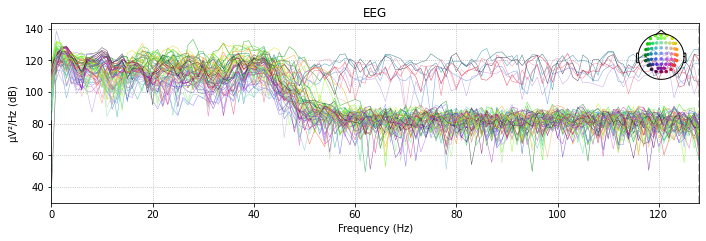

Effective window size : 1.000 (s)


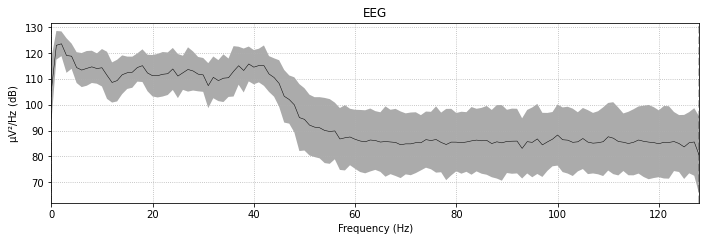

In [36]:
#Plotting power spectral density, frequencies

raw.plot_psd();
raw.plot_psd(average=True);

Effective window size : 1.000 (s)


C:\Users\rantr\AppData\Local\Temp/ipykernel_16608/2099550416.py:1: RuntimeWarning: filter_length (423) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  raw_filtered = raw.copy().filter(8,30, verbose=False);


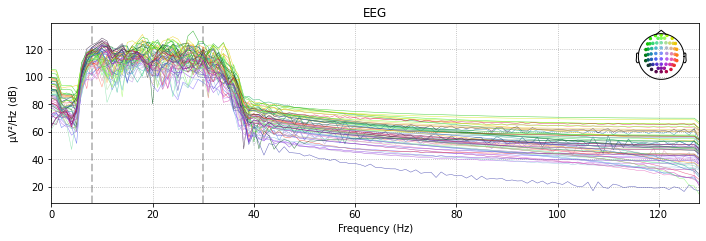

Effective window size : 1.000 (s)


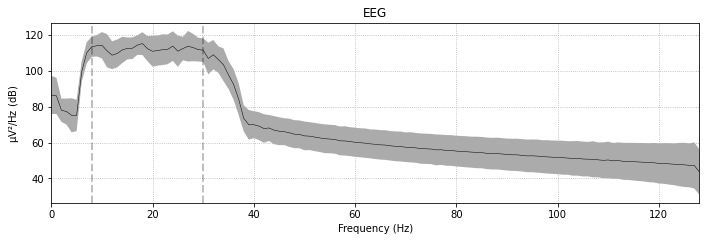

In [37]:
raw_filtered = raw.copy().filter(8,30, verbose=False);
raw_filtered.plot_psd();
raw_filtered.plot_psd(average=True);

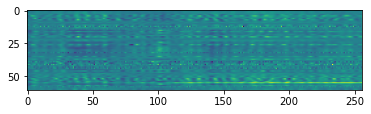

C:\Users\rantr\AppData\Local\Temp/ipykernel_18120/3450553692.py:3: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  plt.imshow(raw.copy().filter(1,10, verbose=False).get_data());


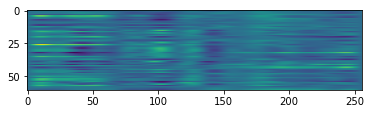

C:\Users\rantr\AppData\Local\Temp/ipykernel_18120/3450553692.py:6: RuntimeWarning: filter_length (423) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  plt.plot(raw.copy().filter(8,30, verbose=False).get_data()[40])


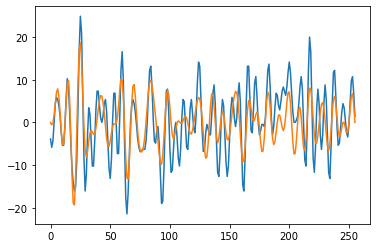

In [61]:
plt.imshow(raw.get_data())
plt.show()
plt.imshow(raw.copy().filter(1,10, verbose=False).get_data());
plt.show()
plt.plot(raw.copy().get_data()[40])
plt.plot(raw.copy().filter(8,30, verbose=False).get_data()[40])

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 0.0s.


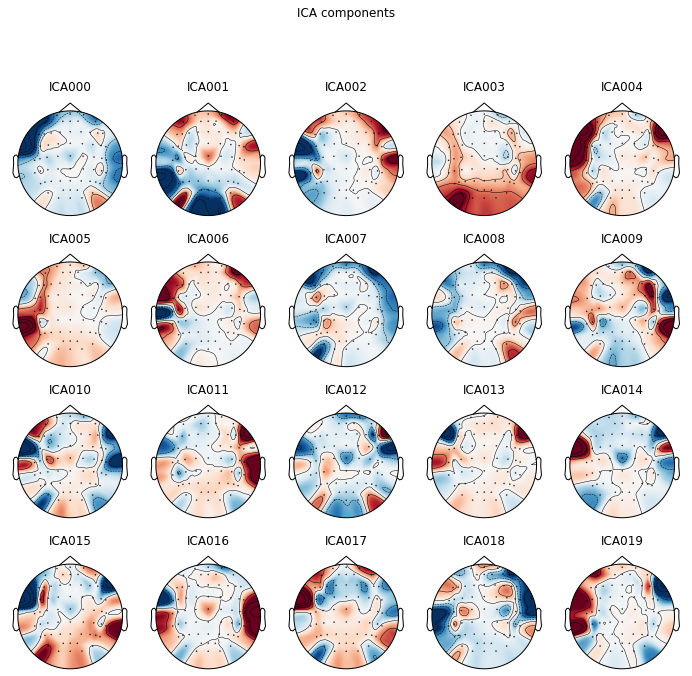

[<MNEFigure size 702x696.24 with 20 Axes>]

In [38]:
#Pre-processing

# set up and fit the ICA
ica = mne.preprocessing.ICA(random_state=42, n_components=20, max_iter=800)
ica.fit(raw_filtered)
ica.plot_components()

In [39]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 61 PCA components


<RawArray | 61 x 256 (1.0 s), ~208 kB, data loaded>